In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from google.colab.patches import cv2_imshow
import imutils
import argparse



In [ ]:
#function to rename the door images, kater on
#def renameImages():

['door.jpg', 'door3.jpeg', 'door_image16.jpg', 'redclose.jpg', 'redopen.jpg', 'room.jpeg']


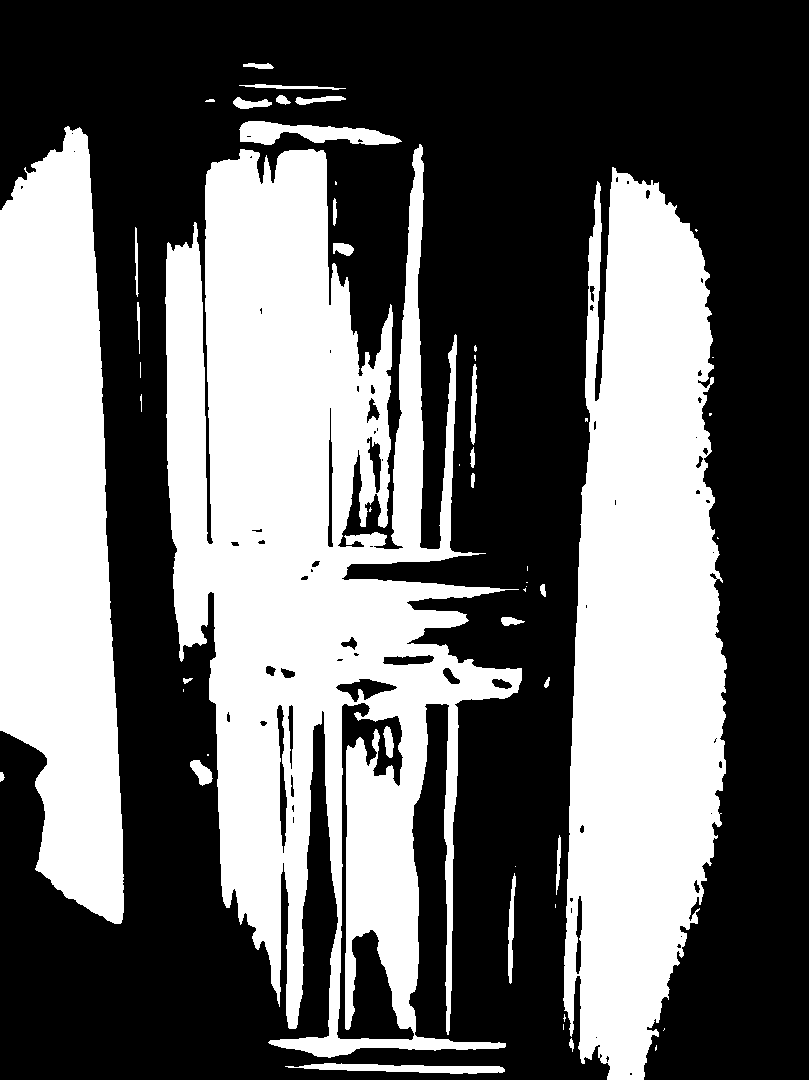

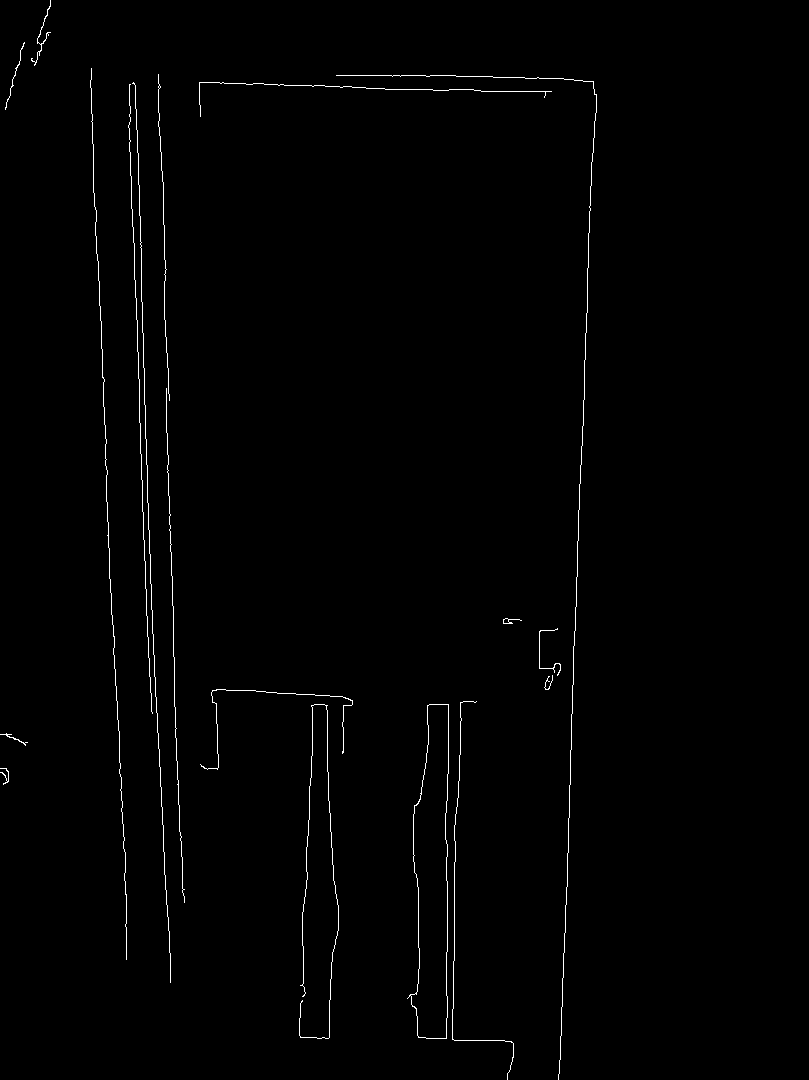

In [ ]:
path = '/content/drive/MyDrive/DoorImages'
door_images = os.listdir(path)

door_images.sort()
print(door_images)

#Load image
img = cv2.imread(path + '/' + door_images[1])

#Covert image to grayscale
grayscale = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#Blur image
blurred_img = cv2.blur(grayscale,(5,5))


#Threshold image
(ret, thresh) = cv2.threshold(blurred_img, 128, 255, cv2.THRESH_BINARY)
cv2_imshow(thresh)
kernel = np.ones((4,4),np.uint8)

morph = cv2.morphologyEx(grayscale, cv2.MORPH_OPEN, kernel)

kernel = np.ones((11,11), np.uint8)
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)

#Canny edge detection
canny_edge = cv2.Canny(morph, 60, 255)
cv2_imshow(canny_edge)



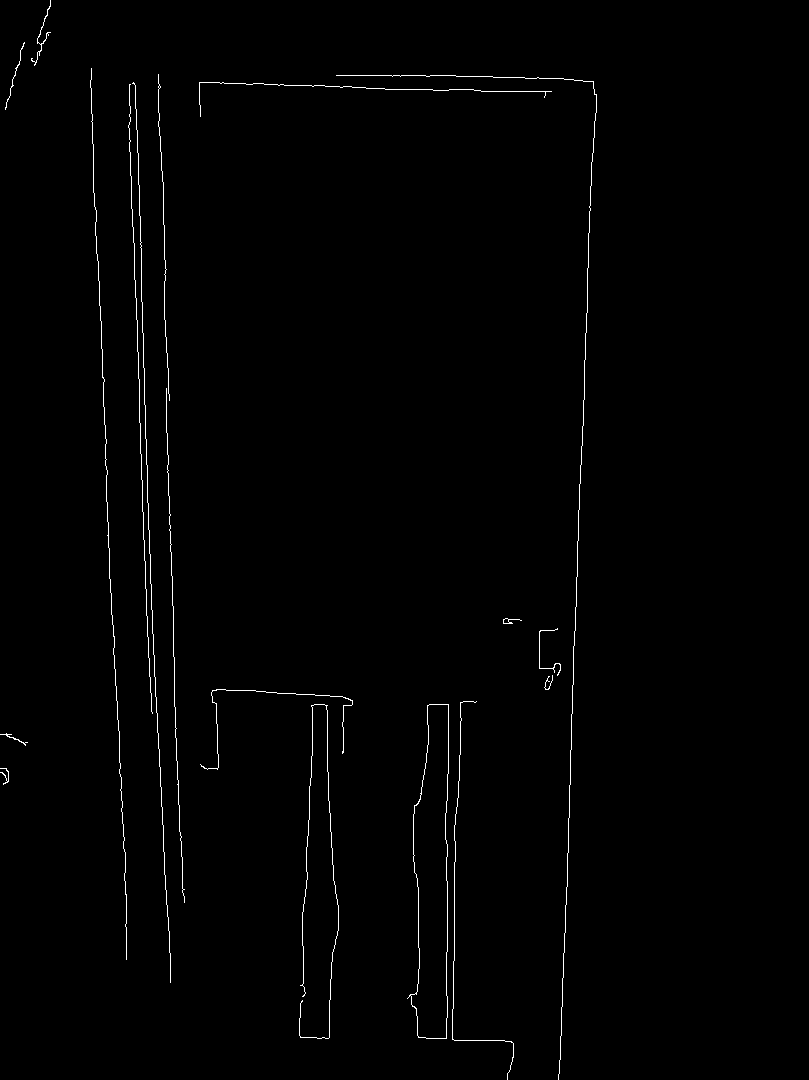

In [ ]:
#find contours
clone = canny_edge.copy()
cv2_imshow(clone)
#contours, hierarchy = cv2.findContours(clone, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)


#create empty image for contours
#img_contour = np.zeros(img.shape)

#draw contours on the empty image
#cv2.drawContours(img_contour, contours, -1, (0,255,0), 3)

#cv2_imshow(img_contour)

In [ ]:
#function that checks if width and height is within a certain ratio, 
def withinAspectRatio(x,y,w,h,lower,upper):
  ratio = h/w
  return ratio < upper and ratio > lower

In [ ]:
#find the intersection of the lines
from collections import defaultdict
def segment_by_angle_kmeans(lines, k=2, **kwargs):
    """Groups lines based on angle with k-means.

    Uses k-means on the coordinates of the angle on the unit circle 
    to segment `k` angles inside `lines`.
    """

    # Define criteria = (type, max_iter, epsilon)
    default_criteria_type = cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER
    criteria = kwargs.get('criteria', (default_criteria_type, 10, 1.0))
    flags = kwargs.get('flags', cv2.KMEANS_RANDOM_CENTERS)
    attempts = kwargs.get('attempts', 10)

    # returns angles in [0, pi] in radians
    angles = np.array([line[0][1] for line in lines])
    # multiply the angles by two and find coordinates of that angle
    pts = np.array([[np.cos(2*angle), np.sin(2*angle)]
                    for angle in angles], dtype=np.float32)

    # run kmeans on the coords
    labels, centers = cv2.kmeans(pts, k, None, criteria, attempts, flags)[1:]
    labels = labels.reshape(-1)  # transpose to row vec

    # segment lines based on their kmeans label
    segmented = defaultdict(list)
    for i, line in enumerate(lines):
        segmented[labels[i]].append(line)
    segmented = list(segmented.values())
    return segmented

In [ ]:
def intersection(line1, line2):
    """
    Find the intersection of two lines 
    specified in Hesse normal form.

    Returns closest integer pixel locations.

    See here:
    https://stackoverflow.com/a/383527/5087436
    """

    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1), np.sin(theta1)],
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))

    return [[x0, y0]]

In [ ]:
def segmented_intersections(lines):
    """
    Find the intersection between groups of lines.
    """

    intersections = []
    for i, group in enumerate(lines[:-1]):
        for next_group in lines[i+1:]:
            for line1 in group:
                for line2 in next_group:
                    intersections.append(intersection(line1, line2)) 

    return intersections

In [ ]:
def drawLines(img, lines, color=(0,0,255)):
    """
    Draw lines on an image
    """
    for line in lines:
        for rho,theta in line:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1,y1), (x2,y2), color, 1)

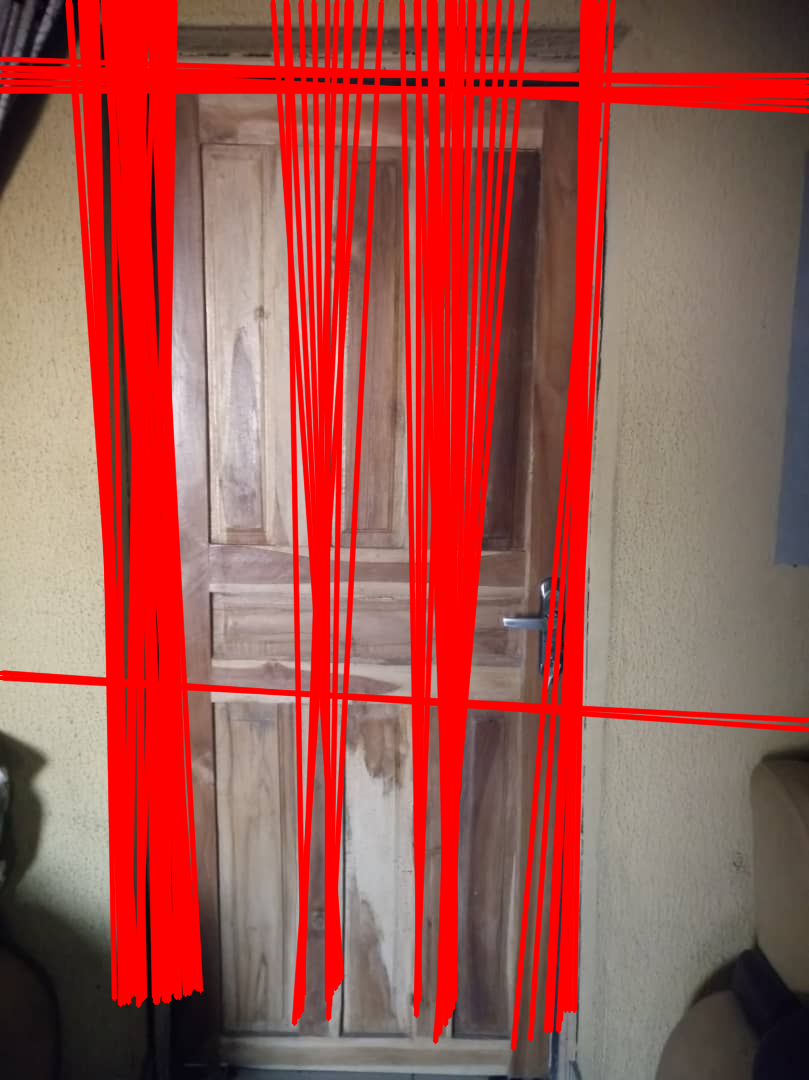

In [ ]:
 #hough transform

color_binary = cv2.cvtColor(canny_edge, cv2.COLOR_GRAY2BGR)
colorP = np.copy(color_binary)

 
Imagelines = cv2.HoughLines(canny_edge, 1, np.pi / 180, 65, None, 0, 0)

if Imagelines is not None:
      for i in range(0, len(Imagelines)):
          rho = Imagelines[i][0][0]
          theta = Imagelines[i][0][1]
          a = math.cos(theta)
          b = math.sin(theta)
          x0 = a * rho
          y0 = b * rho
          pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
          pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
          #need to. check for over laping lines 
          cv2.line(img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)



cv2_imshow(img)

(593, 96)
(594, 78)
(593, 92)
(594, 75)
(594, 80)
(571, 713)
(572, 708)
(593, 89)
(593, 99)
(593, 91)
(123, 79)
(123, 70)
(124, 84)
(123, 75)
(122, 63)
(155, 683)
(155, 686)
(124, 89)
(123, 75)
(124, 91)
(128, 80)
(128, 70)
(128, 84)
(128, 75)
(127, 63)
(149, 683)
(149, 686)
(128, 89)
(128, 75)
(128, 91)
(133, 80)
(133, 70)
(133, 84)
(133, 75)
(132, 64)
(154, 683)
(154, 686)
(133, 89)
(133, 75)
(133, 91)
(154, 80)
(154, 71)
(154, 85)
(154, 75)
(153, 64)
(175, 685)
(175, 687)
(154, 89)
(154, 76)
(154, 91)
(92, 78)
(91, 70)
(92, 84)
(92, 75)
(91, 62)
(113, 681)
(113, 684)
(92, 89)
(92, 73)
(92, 91)
(84, 78)
(84, 69)
(84, 83)
(84, 75)
(83, 62)
(116, 681)
(116, 684)
(85, 89)
(84, 72)
(85, 91)
(135, 80)
(135, 70)
(135, 84)
(135, 75)
(134, 64)
(156, 684)
(156, 686)
(135, 89)
(135, 75)
(135, 91)
(160, 81)
(160, 71)
(161, 85)
(160, 75)
(160, 65)
(171, 685)
(171, 687)
(161, 89)
(160, 76)
(161, 91)
(468, 91)
(469, 76)
(468, 90)
(469, 75)
(469, 75)
(458, 705)
(458, 702)
(469, 89)
(468, 93)
(468, 

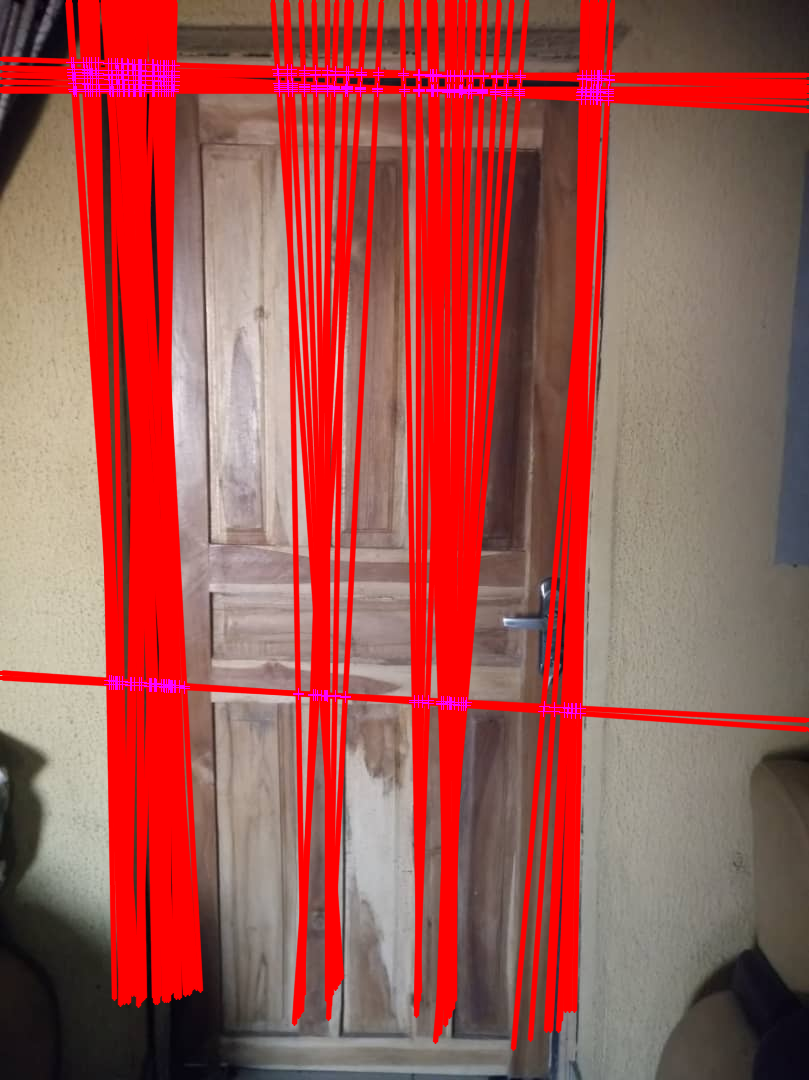

In [ ]:
segmented = segment_by_angle_kmeans(Imagelines)

seg_intersections = segmented_intersections(segmented)

img_with_intersections = np.copy(img) #copy the image



for point in seg_intersections:
    pt = (point[0][0], point[0][1])

    print(pt)
    length = 5
    cv2.line(img_with_intersections, (pt[0], pt[1]-length), (pt[0], pt[1]+length), (255, 0, 255), 1) # vertical line
    cv2.line(img_with_intersections, (pt[0]-length, pt[1]), (pt[0]+length, pt[1]), (255, 0, 255), 1)
    

#get the first point of it and the last then make it!

cv2_imshow(img_with_intersections)




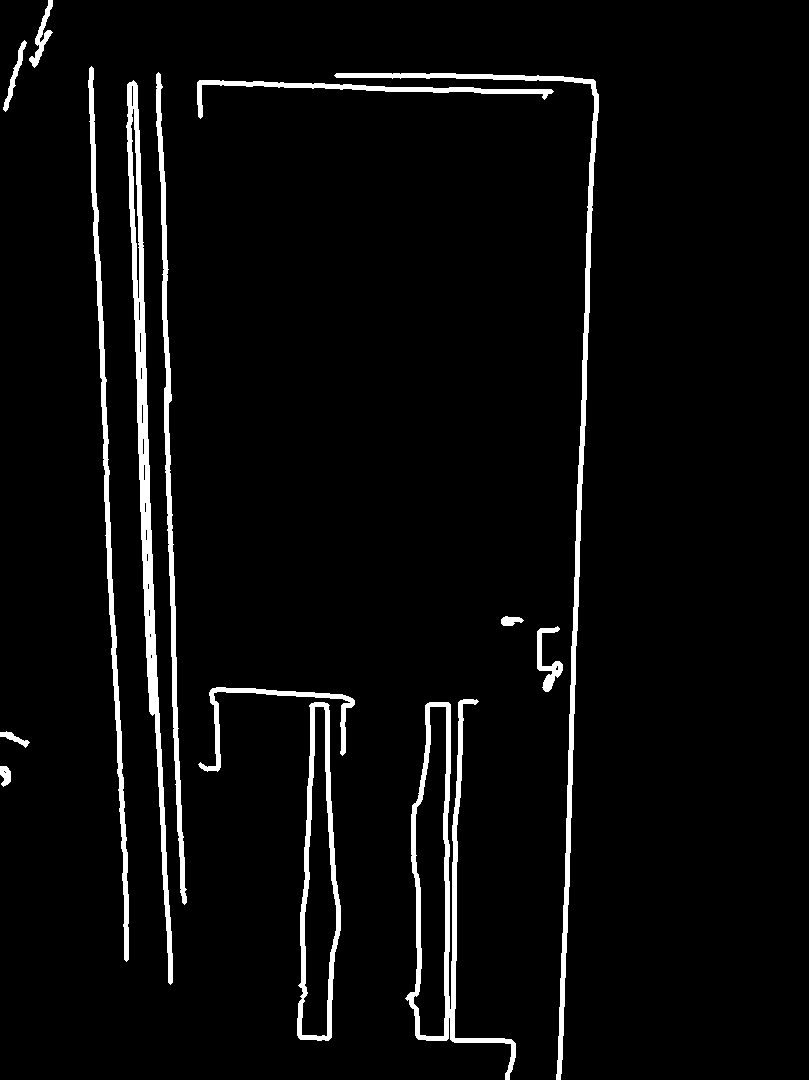

3
5
2
5
2


In [ ]:

# edged is the edge detected image

items = cv2.findContours(clone, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(items)

#cnts = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)






contours, hierarchy = cv2.findContours(clone, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)



#create empty image for contours
img_contour = np.zeros(img.shape)

#draw contours on the empty image, in white
cv2.drawContours(img_contour, contours, -1, (255,255,255), 3)

cv2_imshow(img_contour)

cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    #print(c)
    print(len(approx))
    if len(approx) == 4:
        #screenCnt = approx
        #x,y,w,h = cv2.boundingRect(approx) #returns the four points of the rectangle for the thing
        #if(withinAspectRatio(x,y,w,h,1.81,3.29) == True):
          #cv2.rectangle(clone,(x,y),(x+w,y+h),(0,255,0),thickness=3)
        x,y,w,h = cv2.boundingRect(approx) #returns the four points of the rectangle for the thing
        if(withinAspectRatio(x,y,w,h,1.1,3.1) == True):
          cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),thickness=3)
          cv2_imshow(img)
        
        #cv2_imshow(clone)
        #break
        

In [ ]:
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)